# Monet using GAN

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec
/kaggle/input/gan-getting-started/photo_jpg/fb97febc5f.jpg
/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec


In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa
# from kaggle_datasets import KaggleDatasets

if os.path.exists(r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'):
    datapath = r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'
elif os.path.exists(r'C:\Users\nikok\Documents\Monet using GAN'):
    datapath = r'C:\Users\nikok\Documents\Monet using GAN'
else:
    datapath = r'/kaggle/input/gan-getting-started'
print(datapath)

C:\Users\nikok\Documents\Monet using GAN


In [3]:
tf.__version__

'2.17.1'

### Computing setups

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
strategy = tf.distribute.MirroredStrategy()


Available GPUs: []
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


## Brief description of the problem and data (5 pts)

*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.*

In [4]:
monet_files = os.listdir(os.path.join(datapath, 'monet_tfrec'))
photo_files = os.listdir(os.path.join(datapath, 'photo_tfrec'))
monet_filenames = [os.path.join(datapath, 'monet_tfrec', f) for f in monet_files]
photo_filenames = [os.path.join(datapath, 'photo_tfrec', f) for f in photo_files]
print(20*'*', 'Monet paintings', 20*'*')
print('First filename:', monet_files[0], '\nNumber of files:', len(monet_files))
print(20*'*', 'Photos', 20*'*')
print('First filename:', photo_files[0], '\nNumber of files:', len(photo_files))

******************** Monet paintings ********************
First filename: monet00-60.tfrec 
Number of files: 5
******************** Photos ********************
First filename: photo00-352.tfrec 
Number of files: 20


### Figure out the contents of the tfrec files

From the code below we can see that each record/example contains three fields: 
* target: label of the image. Not needed in this work 
* image_name: name of the image
* image: the actual image data

Both of the data sets appear to have the same structure. 

In [5]:
# The following code is adapted from an answer from Microsoft Copilot
import tensorflow as tf
from google.protobuf.json_format import MessageToJson
import json

def iterate_record(dataset):
    # Initialize a counter
    record_count = 0
    # Iterate through the dataset and count the records
    for _ in dataset:
        record_count += 1
    print(f'Total number of records: {record_count}')
    
    # Iterate through the dataset and parse each record
    for raw_record in dataset.take(1):  # Adjust the number to read more records
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        json_message = MessageToJson(example)
        parsed_record = json.loads(json_message)
        print(json.dumps(parsed_record, indent=2)[0:500])

# Create a TFRecordDataset
print(20*'*', 'Monet paintings', 20*'*')
raw_monet_dataset = tf.data.TFRecordDataset(monet_filenames)
iterate_record(raw_monet_dataset)

print('\n' + 20*'*', 'Photos', 20*'*')
raw_photo_dataset = tf.data.TFRecordDataset(photo_filenames)
iterate_record(raw_photo_dataset)


******************** Monet paintings ********************
Total number of records: 300
{
  "features": {
    "feature": {
      "target": {
        "bytesList": {
          "value": [
            "bW9uZXQ="
          ]
        }
      },
      "image_name": {
        "bytesList": {
          "value": [
            "MjVjOTkwNDc4Mg=="
          ]
        }
      },
      "image": {
        "bytesList": {
          "value": [
            "/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgo

******************** Photos ********************
Total number of records: 7038
{
  "features": {
    "feature": {
      "target": {
        "bytesList": {
          "value": [
            "cGhvdG8="
          ]
        }
      },
      "image_name": {
        "bytesList": {
          "value": [
            "MGI5MWYzNTljNQ=="
          ]
        }
      },
      "image": {
        "bytesList": {
          "va

We can parse the data now since the structure of the tfrecord is known.

One way:

In [8]:
def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def parse_tfrecord_fn(example):
    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["image"] = normalize(example["image"])
    return example

def decode_image(tf_image):
    return ((tf_image['image'].numpy() + 1) * 127.5).astype(int)

monet_dataset = raw_monet_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
photo_dataset = raw_photo_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

Another way:

In [12]:
# Define the feature description for the TFRecord file
feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string),  # Scalar string
    'image': tf.io.FixedLenFeature([], tf.string),      # Scalar string (encoded image)
    'target': tf.io.FixedLenFeature([], tf.string)       # Scalar integer
}

# Function to parse a single example
def parse_example(example):
    # Parse the example using the feature description
    parsed_example = tf.io.parse_single_example(example, feature_description)
    
    # Decode the image from a string
    image = tf.io.decode_jpeg(parsed_example['image'], channels=3)  # Decode JPEG image
    image = tf.image.resize(image, [256, 256])                     # Resize to desired size
    
    # Extract the target and convert to one-hot (if needed)
    target = parsed_example['target']
    
    return image, target

# Load TFRecord dataset
def load_tfrecord_dataset(tfrecord_file, batch_size):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)  # Load the TFRecord file
    parsed_dataset = raw_dataset.map(parse_example)       # Parse each example
    
    # Batch and shuffle the dataset for training
    dataset = (parsed_dataset
               .repeat(100)
               .shuffle(300*100)  # Shuffle buffer size
               .batch(batch_size)  # Batch size
               .prefetch(tf.data.experimental.AUTOTUNE))  # Prefetch for efficiency
    
    return dataset

# Example usage
tfrecord_file = 'path/to/your/tfrecord/file.tfrecord'
BATCH_SIZE = 32
monet_ds = load_tfrecord_dataset(monet_filenames, batch_size)

# Iterate through the dataset
for images, targets in monet_ds.take(1):
    print(images.shape, targets.shape)
    

(32, 256, 256, 3) (32,)


In [7]:
dims = []
for i, data in enumerate(photo_dataset):
    img = data['image'].numpy().shape
    dims.append(img)
print('Number of images in photos dataset:', i+1)
print('Unique shapes of the photos data:', set(dims))

dims = []
for i, data in enumerate(monet_dataset):
    dims.append(data['image'].numpy().shape)
print('Number of images in Monet dataset:', i+1)
number_of_monets = i+1
print('Unique shapes of the Monet data:', set(dims))

NameError: name 'photo_dataset' is not defined

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*

In [8]:
fig = plt.figure(figsize=(12, 6))
i = 0
for data in monet_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(decode_image(data))
    i += 1
for data in photo_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(decode_image(data))
    i += 1
fig.suptitle('Examples of Monet and photos')
plt.show()

NameError: name 'monet_dataset' is not defined

<Figure size 1200x600 with 0 Axes>

Let's check distribution of real image vs Monet paintings.

In [42]:
def plot_histogram(dataset, title):
    rgb = []
    rgb = [decode_image(d) for d in dataset]
    # for data in dataset:
    #     rgb.append(decode_image(data))
    rgb = np.array(rgb)
    # rgb.shape
    pic_channels = ['red', 'green', 'blue']
    rgb_df = pd.DataFrame()
    for i, clr in enumerate(pic_channels):
        df = pd.DataFrame(rgb[:,:,:,i].ravel(), columns=['val'])
        df['color'] = clr
        rgb_df = pd.concat([rgb_df, df])
    print('Minimum and maximmum values in ' + title + ' data: ', min(rgb_df.val), '&', max(rgb_df.val))
    sns.histplot(rgb_df.sample(1000), x='val', hue='color', bins=30, multiple='dodge', color=['green', 'blue', 'red'])
    plt.grid()
    plt.title('Histogram of ' + title)
    plt.show()


Minimum and maximmum values in sample photos data:  0 & 255


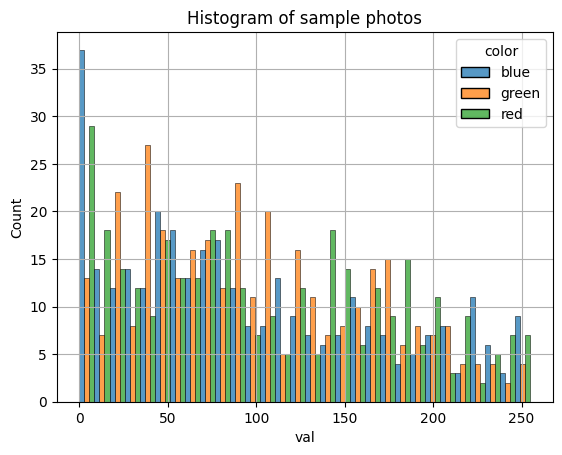

Minimum and maximmum values in Monet paintings data:  0 & 255


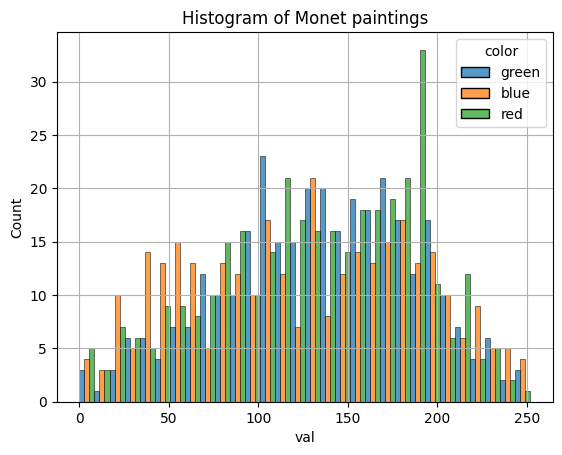

In [43]:
plot_histogram(photo_dataset.take(300), title='sample photos')
plot_histogram(monet_dataset.take(300), title='Monet paintings')


After the EDA is done, we set the batch size of the dataset for training.

Below mostly from https://www.tensorflow.org/datasets/performances

In [10]:
BATCH_SIZE = 32
# ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
monet_dataset = monet_dataset.cache()
# For true randomness, we set the shuffle buffer to the full dataset size.
monet_dataset = monet_dataset.shuffle(number_of_monets*100).repeat(100)
# Batch after shuffling to get unique batches at each epoch.
monet_dataset = monet_dataset.batch(BATCH_SIZE, drop_remainder=True)
monet_dataset = monet_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# .shuffle(10000, reshuffle_each_iteration=True).repeat(repeats))

## Model Architecture (25 pts)

*Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.*

### Discriminator
Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [9]:
with strategy.scope():
    my_discriminator = keras.Sequential(
        [
            keras.Input(shape=(256, 256, 3)),
            layers.Conv2D(int(64), kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(128), kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(128), kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
    my_discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,961 (2.02 MB)

 Trainable params: 528,321 (2.02 MB)

 Non-trainable params: 640 (2.50 KB)

#### Generator

Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [10]:
with strategy.scope():
    latent_dim = 128
    my_generator = keras.Sequential(
        [
            keras.Input(shape=(latent_dim,)),
            layers.Dense(8 * 8 * 128),
            layers.Reshape((8, 8, 128)),
            layers.Conv2DTranspose(int(128), kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(256), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(512), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    my_generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 512)  │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256, 256, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,983,235 (15.19 MB)

 Trainable params: 3,981,443 (15.19 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [13]:
random_latent_vectors = keras.random.normal(shape=(BATCH_SIZE, latent_dim), seed=123)
generated_images = my_generator(random_latent_vectors)


3


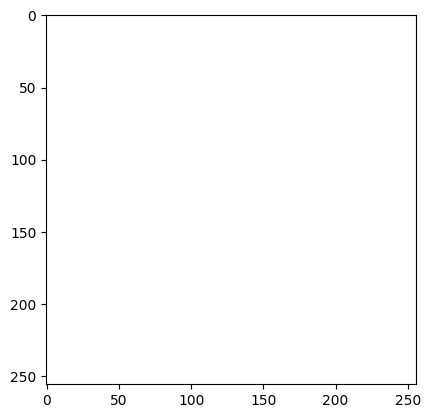

In [33]:
print(generated_images.shape[0])
plt.imshow(generated_images[0])
plt.show()

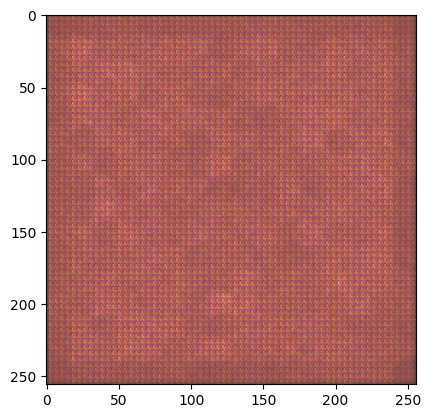

In [32]:
epoch = 1
num_img = 3
random_latent_vectors = keras.random.normal(shape=(num_img, latent_dim), seed=123)
generated_images = my_generator(random_latent_vectors)
generated_images *= 255
generated_images.numpy()
for i in range(num_img):
    img = keras.utils.array_to_img(generated_images[i])
    plt.imshow(img)


#### Training

Override the train step.

Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [20]:
with strategy.scope():
    class GAN(keras.Model):
        def __init__(self, discriminator, generator, latent_dim):
            super().__init__()
            self.discriminator = discriminator
            self.generator = generator
            self.latent_dim = latent_dim
            self.seed_generator = keras.random.SeedGenerator(1337)
    
        def compile(self, d_optimizer, g_optimizer, loss_fn):
            super().compile()
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer
            self.loss_fn = loss_fn
            self.d_loss_metric = keras.metrics.Mean(name="d_loss")
            self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    
        @property
        def metrics(self):
            return [self.d_loss_metric, self.g_loss_metric]
    
        def train_step(self, real_images):
            # Sample random points in the latent space
            # real_images = real_images['image']
            real_images = real_images[0]
            batch_size = keras.ops.shape(real_images)[0]
            random_latent_vectors = keras.random.normal(
                shape=(batch_size, self.latent_dim), seed=self.seed_generator
            )
    
            # Decode them to fake images
            generated_images = self.generator(random_latent_vectors)
    
            # Combine them with real images
            combined_images = keras.ops.concatenate([generated_images, real_images], axis=0)
    
            # Assemble labels discriminating real from fake images
            labels = keras.ops.concatenate(
                [keras.ops.ones((batch_size, 1)), keras.ops.zeros((batch_size, 1))], axis=0
            )
            # Add random noise to the labels - important trick!
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
            # Train the discriminator
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_images)
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
    
            # Sample random points in the latent space
            random_latent_vectors = keras.random.normal(
                shape=(batch_size, self.latent_dim), seed=self.seed_generator
            )
    
            # Assemble labels that say "all real images"
            misleading_labels = keras.ops.zeros((batch_size, 1))
    
            # Train the generator (note that we should *not* update the weights
            # of the discriminator)!
            with tf.GradientTape() as tape:
                predictions = self.discriminator(self.generator(random_latent_vectors))
                g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    
            # Update metrics
            self.d_loss_metric.update_state(d_loss)
            self.g_loss_metric.update_state(g_loss)
            return {
                "d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result(),
            }


#### Callbacks

Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [21]:
with strategy.scope():
    class GANMonitor(keras.callbacks.Callback):
        def __init__(self, num_img=3, latent_dim=128):
            self.num_img = num_img
            self.latent_dim = latent_dim
            self.seed_generator = keras.random.SeedGenerator(42)
    
        def on_epoch_end(self, epoch, logs=None):
            random_latent_vectors = keras.random.normal(
                shape=(self.num_img, self.latent_dim), seed=self.seed_generator
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images[i])
                img.save("generated_img_%03d_%d.png" % (epoch, i))


#### Training

Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [25]:
epochs = 5  # In practice, use ~100 epochs
with strategy.scope():
    gan = GAN(discriminator=my_discriminator, generator=my_generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss_fn=keras.losses.BinaryCrossentropy(),
    )
gan.build(input_shape=(None, 256, 256, 3))
gan.fit(monet_ds, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/5
      2/Unknown 20s 1s/step - d_loss: 9.3843 - g_loss: 0.8154 

ResourceExhaustedError: Graph execution error:

Detected at node generator_1/conv2d_transpose_5_1/conv_transpose defined at (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap

  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "<ipython-input-20-13a6f2b906eb>", line 32, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py", line 192, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 1238, in conv_transpose

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 415, in conv_transpose

OOM when allocating tensor with shape[32,512,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node generator_1/conv2d_transpose_5_1/conv_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_16496]

## Results and Analysis (35 pts)

*Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.*

*Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.*

## Conclusion (15 pts)

*Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?*

# Sources

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
https://keras.io/examples/generative/dcgan_overriding_train_step
